In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
import nltk.data
import gensim.downloader as model_api
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer as TFID

# might need to uncomment and run below depending on what libraries you have
# nltk.download('punkt')

## 1: Face Recognition, but not evil this time

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 80% accuracy.

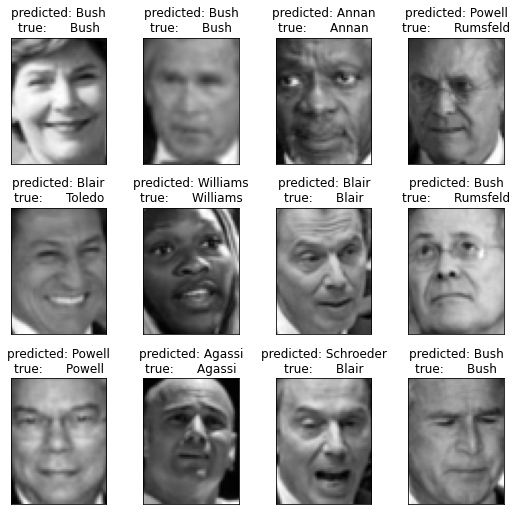

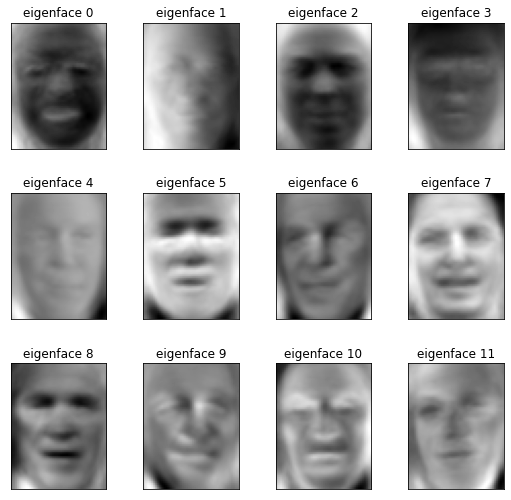

0.9591836734693877
0.7841726618705036


C:\Users\gaia_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2]:
faces = fetch_lfw_people(min_faces_per_person=30)

n_samples, h, w = faces.images.shape

X = faces.data
n_features = X.shape[1]

y = faces.target
target_names = faces.target_names
n_classes = target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

n_components = 150

pca = PCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

def pics(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

pics(X_test, prediction_titles, h, w)


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
pics(eigenfaces, eigenface_titles, h, w)

plt.show()

LogReg = LogisticRegression(random_state=0).fit(X, y)
print(LogReg.score(X, y))
print(accuracy_score(y_test, y_pred))

# 2: Bag of Words, Bag of Popcorn

By this point, you are ready for the [Bag of Words, Bag of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data) competition. 

Use NLP feature pre-processing (using, SKLearn, Gensim, Spacy or Hugginface) to build the best classifier you can. Use a  feature pipeline, and gridsearch for your final model.

A succesful project should get 80% or more on a **holdout** dataset you kept for yourself.

In [3]:
train = pd.read_csv("data/labeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3)

test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv("data/unlabeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3)

def words_list(review):
    word_check = BeautifulSoup(review).get_text()
    word_check = re.sub("[^a-zA-Z]"," ", word_check)
    words = word_check.lower().split()
    return(words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def make_sentences(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentence = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentence.append(words_list(raw_sentence))
    return sentence

sentences = []

for review in train["review"]:
    sentences += make_sentences(review, tokenizer)

for review in unlabeled_train["review"]:
    sentences += make_sentences(review, tokenizer)
    
num_features = 300
model = model_api.load("glove-wiki-gigaword-300")
model.init_sims(replace=True)

def Feature_Vec(words, model, num_features):
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    word_index = set(model.wv.index2word)
    
    for word in words:
        if word in word_index: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
            
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def Avg_Feature_Vec(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = Feature_Vec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

train_rev = []
for review in train["review"]:
    train_rev.append(" ".join(words_list(review)))

trains = Avg_Feature_Vec(train_rev, model, num_features)

test_rev = []
for review in test["review"]:
    test_rev.append(" ".join(words_list(review)))

tests = Avg_Feature_Vec(test_rev, model, num_features)

forest = RandomForestClassifier(n_estimators = 100)

forest = forest.fit(trains, train["sentiment"])

result = forest.predict(tests)

output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("popcorn.csv", index=False, quoting=3)

C:\Users\gaia_\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\gaia_\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\gaia_\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\gaia_\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. Yo

In [4]:
vctrzr = TFID()

X_sum = train_rev

vctrzr.fit(X_sum)
X_sum = vctrzr.transform(X_sum)

X = X_sum[:len(train_rev)]
y_train = train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y_train)

param_grid = {'C':[30]}

LogReg = GridSearchCV(LogisticRegression(penalty = 'l2', random_state = 0), param_grid, cv = 7)

LogReg.fit(X_train,y_train)

y_pred = LogReg.predict(X_test)
print(f"{np.sum(y_test == y_pred)} / {len(y_test)} correct")
LogReg.score(X_test, y_test)

C:\Users\gaia_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gaia_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

5544 / 6250 correct


C:\Users\gaia_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.88704